<div align=center><h1 style="display: inline;" >2. K-Means Clustering (A1)</h1><img style="display: inline;" src=http://industrypulse.com/wp-content/uploads/2017/05/h2oai-1068x1068.png width=100></div>

A common problem in unsupervised learning consists of identifying clusters in multi-dimensional space. In the K-means approach, the problem is formulated as identifying centers for each of $k$ clusters, $\boldsymbol{\mu}_k$, as well as assignments of the $n$ points to the $k$ centers, $r_{nk} \in \{0,1\}$. The problem can be formulated as minimizing the following objective function:

<p><div align=center>$\begin{align}J &= \sum_{n,k} r_{nk} \lVert \mathbf{x}_n - \boldsymbol{\mu}_k \rVert^{2}\end{align}$</div></p>

The assignment of points to clusters is done in an iterative procedure (reminiscent of the expectation-maximation algorithm). First we initialize the means $\boldsymbol{\mu}_k$ and minimize $J$ by setting $r_{nk}$. Then, given $r_{nk}$, we adjust the $\boldsymbol{\mu}_k$ to minimize $J$.

The first step is optimized by assigning $r_{nk} = 1$ for the closest $\boldsymbol{\mu}_k$ to each $\mathbf{x}_n$. Then, to set the means, minimize $J$ by setting the derivative to zero, which gives:
<p><div align=center>$\mathbf{\mu}_k = \frac{\sum_n r_{nk}\mathbf{x}_n}{\sum_n r_{nk}}$</div></p>

Thus, on each iteration we simply set the $\boldsymbol{\mu}_k$ equal to the means of the component $\mathbf{x}_n$ — hence "K-means."

**Visualizing the iris data.** We first load the data into R, so we can visualize its three species spread over four dimensions. As can be seen, there is fairly distinct clustering of the three species samples (although with some overlapping of versicolor and virginica). We expect our k-means clustering algorithm to cleanly separate the species (with some likely confusion of versicolor and virginica). 

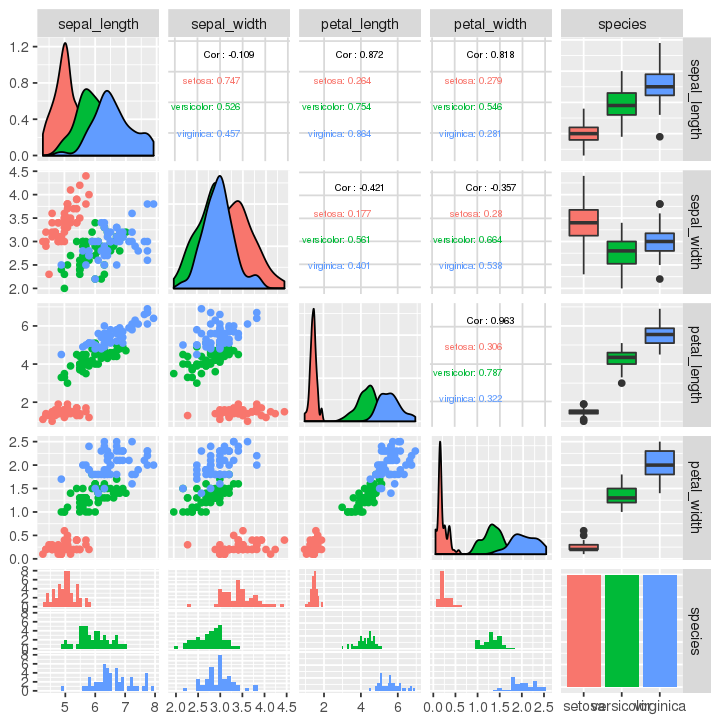

In [5]:
library(GGally)
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

iris_df <- read.csv("../data/iris.csv")
ggpairs(data = iris_df, mapping = ggplot2::aes(color = species), upper = list(continuous = wrap("cor", size = 2)), lower = list(combo = wrap("facethist", binwidth = 0.1)))


**Importing the iris data to H2O:**

In [6]:
library(h2o)
h2o.init(nthreads = -1)
iris_hex = as.h2o(iris_df)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         6 minutes 35 seconds 
    H2O cluster version:        3.14.0.6 
    H2O cluster version age:    9 days  
    H2O cluster name:           ec2-user 
    H2O cluster total nodes:    2 
    H2O cluster total memory:   1.53 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.1 (2017-06-30) 

  |======================================================================| 100%


In [7]:
iris_hex <- as.h2o(iris_df)

  |======================================================================| 100%


**Mean properties by species:**

In [8]:
mean_hex <- h2o.group_by(iris_hex, 'species', mean('sepal_length'), mean('sepal_width'), mean('petal_length'), mean('petal_width'))
mean_hex

     species mean_sepal_length mean_sepal_width mean_petal_length
1     setosa             5.006            3.418             1.464
2 versicolor             5.936            2.770             4.260
3  virginica             6.588            2.974             5.552
  mean_petal_width
1            0.244
2            1.326
3            2.026

[3 rows x 5 columns] 

**K-means clustering:** Performing clustering in H2O, the first thing to note is that the algorithm is not deterministic. Running the following several times gives different results. This is because the initial centers are chosen at random. The methods of choosing the centers can be set as a parameter ("Random","Furthest","PlusPlus"), but all involve choosing at least one center randomly.

In [9]:
kmmodel = h2o.kmeans(iris_hex[,c('sepal_length','sepal_width','petal_length','petal_width')],k=3)
kmmodel@model$centers

  |======================================================================| 100%


centroid,sepal_length,sepal_width,petal_length,petal_width
1,5.786538,2.669231,4.365385,1.415385
2,5.006000,3.418000,1.464000,0.244000
3,6.777083,3.091667,5.491667,1.958333


We can see the iterative progress as follows. The model sorts all the samples into clusters in a few iterations (depending on random starting point):

In [10]:
kmmodel@model$scoring_history

timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
2017-10-19 19:58:55,0.061 sec,0,NaN,NaN
2017-10-19 19:58:55,0.202 sec,1,150,316.4488
2017-10-19 19:58:55,0.251 sec,2,5,140.5602
2017-10-19 19:58:55,0.256 sec,3,0,140.0286


Next, we note that the centers are close to the aggregate means, but not exact (sometimes the setosa center is exact). This indicates that the clustering was not exactly by species. 

We can see the clusters the points are assigned to as follows:

In [11]:
library("plyr")
clustered_hex <- predict(kmmodel, iris_hex)
k <- as.data.frame(clustered_hex)
clustered_df <- cbind(iris_df, k)
clustered_df = rename(clustered_df, c("predict"="cluster"))
clustered_df[sample(nrow(clustered_df), 20), ]

  |======================================================================| 100%


,sepal_length,sepal_width,petal_length,petal_width,species,cluster
76,6.6,3.0,4.4,1.4,versicolor,2
63,6.0,2.2,4.0,1.0,versicolor,0
73,6.3,2.5,4.9,1.5,versicolor,0
1,5.1,3.5,1.4,0.2,setosa,1
45,5.1,3.8,1.9,0.4,setosa,1
71,5.9,3.2,4.8,1.8,versicolor,2
60,5.2,2.7,3.9,1.4,versicolor,0
18,5.1,3.5,1.4,0.3,setosa,1
128,6.1,3.0,4.9,1.8,virginica,2
95,5.6,2.7,4.2,1.3,versicolor,0


We can then create the equivalent of a confusion matrix:

In [12]:
conf_df <- data.frame(cluster=c(0,1,2),setosa=c(0,0,0),virginica=c(0,0,0),versicolor=c(0,0,0))
for (species in c('setosa','virginica','versicolor')) {
    for (i in 1:3) {
        conf_df[i,species] <- sum((clustered_df['cluster'] == i-1)&(clustered_df['species'] == species))
    }
}
conf_df

cluster,setosa,virginica,versicolor
0,0,14,38
1,50,0,0
2,0,36,12


There is significant overlap between virginica and versicolor; in fact, if we allow the algorithm to estimate the number of clusters, it determines that there are only two (setosa vs. virginica/versicolor):

In [13]:
kmmodel <- h2o.kmeans(iris_hex[,c('sepal_length','sepal_width','petal_length','petal_width')],estimate_k=TRUE,k=10)
kmmodel@model$centers

  |======================================================================| 100%


centroid,sepal_length,sepal_width,petal_length,petal_width
1,6.262,2.872,4.906,1.676
2,5.006,3.418,1.464,0.244


We want to address the discrepancy between the means for each species and the calculated centers. Let's start by initializing the clustering algorithm with the raw means, and see if the discrepancy still exists:

In [14]:
mean_df <- as.data.frame(mean_hex)
print("Species means: ")
mean_df
startpoints <- mean_df[,c('mean_sepal_length','mean_sepal_width','mean_petal_length','mean_petal_width')]
kmmodel <- h2o.kmeans(iris_hex[,c('sepal_length','sepal_width','petal_length','petal_width')],k=3,user_points=startpoints)
print("Centroids: ")
kmmodel@model$centers

[1] "Species means: "


species,mean_sepal_length,mean_sepal_width,mean_petal_length,mean_petal_width
setosa,5.006,3.418,1.464,0.244
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


  |======================================================================| 100%
  |======================================================================| 100%
[1] "Centroids: "


centroid,sepal_length,sepal_width,petal_length,petal_width
1,5.006000,3.418000,1.464000,0.244000
2,5.801887,2.673585,4.369811,1.413208
3,6.780851,3.095745,5.510638,1.972340


We see that there is still confusion between versicolor and virginica, of roughly the same frequency:

In [15]:
clustered_hex <- predict(kmmodel, iris_hex)
k <- as.data.frame(clustered_hex)
clustered_df <- cbind(iris_df, k)
clustered_df <- rename(clustered_df, c("predict"="cluster"))
conf_df <- data.frame(cluster=c(0,1,2),setosa=c(0,0,0),virginica=c(0,0,0),versicolor=c(0,0,0))

for (species in c('setosa','virginica','versicolor')) {
    for (i in 1:3) {
        conf_df[i,species] <- sum((clustered_df['cluster'] == i-1)&(clustered_df['species'] == species))
    }
}
conf_df

  |======================================================================| 100%


cluster,setosa,virginica,versicolor
0,50,0,0
1,0,14,39
2,0,36,11


Thus, even when initialized with the species means the optimal cluster centers are computed to be at different locations. 

Next, let's compare how our clustering would fare if we used species means as cluster centers. 

First, however, we should make a note about standardization. Since variables may differ considerably in terms of magnitude (thus affecting the distance calculation) it is good practice to standardize all variables to the same scale. This is done by default by the H2O K-means algorithm. Thus, we should do the same for a fair comparison.

Standardizing:

In [16]:
for (i in 1:4) {
   clustered_df[,i] <- (clustered_df[,i] - mean(clustered_df[,i])) / sd(clustered_df[,i])
}
clustered_df

sepal_length,sepal_width,petal_length,petal_width,species,cluster
-0.89767388,1.0286113,-1.336794,-1.3085928,setosa,0
-1.13920048,-0.1245404,-1.336794,-1.3085928,setosa,0
-1.38072709,0.3367203,-1.393470,-1.3085928,setosa,0
-1.50149039,0.1060900,-1.280118,-1.3085928,setosa,0
-1.01843718,1.2592416,-1.336794,-1.3085928,setosa,0
-0.53538397,1.9511326,-1.166767,-1.0465248,setosa,0
-1.50149039,0.7979809,-1.336794,-1.1775588,setosa,0
-1.01843718,0.7979809,-1.280118,-1.3085928,setosa,0
-1.74301699,-0.3551707,-1.336794,-1.3085928,setosa,0
-1.13920048,0.1060900,-1.280118,-1.4396268,setosa,0


Recalculating the means:

In [41]:
mean_df = aggregate(clustered_df[,c(1:4)], by=list(clustered_df$species), FUN=mean)
mean_df

Group.1,sepal_length,sepal_width,petal_length,petal_width
setosa,-1.0111914,0.8394944,-1.3005215,-1.250938
versicolor,0.1119073,-0.6549901,0.2841349,0.166850
virginica,0.8992841,-0.1845043,1.0163866,1.084088


Let's classify each sample to the closest species mean:

In [42]:
clustered_df[,"closest"] = 0
for (i in 1:nrow(clustered_df)) {
   for (j in 1:3) {
      clustered_df[i,paste("mean dist",j)] = sum((clustered_df[i,1:4] - mean_df[j,2:5])^2)
   }
   clustered_df[i,"min"] = min(clustered_df[i,"mean dist 1"], clustered_df[i,"mean dist 2"], clustered_df[i,"mean dist 3"])
   for (j in 1:3) {
      if (clustered_df[i,"min"] == clustered_df[i,paste("mean dist",j)]) {
          clustered_df[i,"closest"] = j-1
      } 
   }
}
clustered_df[sample(nrow(clustered_df), 10), ]
conf_df <- data.frame(cluster=c(0,1,2),setosa=c(0,0,0),virginica=c(0,0,0),versicolor=c(0,0,0))
for (species in c('setosa','virginica','versicolor')) {
    for (i in 1:3) {
        conf_df[i,species] <- sum((clustered_df['closest'] == i-1)&(clustered_df['species'] == species))
    }
}
conf_df

,sepal_length,sepal_width,petal_length,petal_width,species,cluster,closest,mean dist 1,mean dist 2,mean dist 3,min
136,2.2421720,-0.1245404,1.3269702,1.4431211,virginica,2,2,25.67540227,7.5357779,2.0323106,2.03231059
145,1.0345390,0.5673506,1.1002669,1.7051890,virginica,2,2,18.76154586,5.3779247,0.9763822,0.97638216
80,-0.1730941,-1.0470617,-0.1466015,-0.2603209,versicolor,1,1,6.57435447,0.6029546,5.0539765,0.60295461
142,1.2760656,0.1060900,0.7602119,1.4431211,virginica,2,2,17.27400179,3.7900245,0.4209396,0.42093961
134,0.5514857,-0.5858010,0.7602119,0.3948491,virginica,1,1,11.42866360,0.4766493,0.8226784,0.47664925
120,0.1891958,-1.9695830,0.7035360,0.3948491,virginica,1,1,16.05670682,1.9620089,4.2636571,1.96200895
41,-1.0184372,1.0286113,-1.3934699,-1.1775588,setosa,0,0,0.04984158,8.7339850,16.0717583,0.04984158
129,0.6722490,-0.5858010,1.0435910,1.1810531,virginica,2,2,16.27488220,1.9241516,0.2227263,0.22272632
110,1.6383555,1.2592416,1.3269702,1.7051890,virginica,2,2,22.83868509,9.4483199,3.1128575,3.11285748
117,0.7930124,-0.1245404,0.9869152,0.7879511,virginica,2,2,13.57394892,1.6249478,0.1034549,0.10345493


cluster,setosa,virginica,versicolor
0,50,0,0
1,0,12,40
2,0,38,10


As we can see, we get very similar classification results. Of course, the difference is that k-means was <em>unsupervised</em> learning — we did not need to know the species of the plants to compute the clusters (although we did need to know the number of species/clusters).